In [443]:
%matplotlib inline
import numpy as np
import scipy
from matplotlib import pylab as plt
from matplotlib import rc
from matplotlib import rcParams
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso

In [444]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rcParams['text.latex.preamble'] = ["\usepackage{amsmath} "]

In [445]:
%config InlineBackend.figure_format = 'retina'

In [446]:
def ss_estimations(X_lab, X_all, y):
    InverseMatrix = np.linalg.inv(np.dot(np.transpose(X_all), X_all))
    beta = np.dot(np.dot(InverseMatrix, np.transpose(X_lab)), y)
    return beta / len(X_lab[:, 1]) * len(X_all[:,1])

def ols_estimations(X_lab, y):
    InverseMatrix = np.linalg.inv(np.dot(np.transpose(X_lab), X_lab))
    beta = np.dot(np.dot(InverseMatrix, np.transpose(X_lab)), y)
    return beta

def lasso_estimation(A, X, y, lamda = 1, iterations = 200):
    beta = np.ones((len(X[0,:])))
    dim = len(X[0, :])
    n_lab = len(X)
    for iterations_number in range(iterations):
        for i in range(len(beta)):
            A_i = A[:, i]
            first_coef = np.linalg.norm(A_i) ** 2 
            second_coef = np.dot(y,  X[:, i]) / n_lab - np.dot(np.dot(A_i,  A[:, np.arange(dim)!=i]), beta[np.arange(dim)!=i])
            if (second_coef - lamda) > 0:
                beta[i] = (second_coef - lamda)/(first_coef)
            elif (second_coef + lamda) < 0:
                beta[i] = (second_coef + lamda)/(first_coef)
            else:
                beta[i] = 0
    return beta

def generate_linear_data(n = 100, test_n = 5000, dim = 5, sparse = False):

    mu = range(dim)
    Sigma = np.random.normal(10, 10, dim * dim)
    Sigma = np.reshape(Sigma, (dim, dim))
    Sigma = np.dot(np.transpose(Sigma), Sigma)
    X = np.random.multivariate_normal(mu, Sigma, size = n)
    X = normalize(X)
    y = np.sum(X, axis = 1) + np.random.normal(0, 1, n)
    X_test = np.random.multivariate_normal(mu, Sigma, size = test_n)
    X_test = normalize(X_test)
    y_test = np.sum(X_test, axis = 1) + np.random.normal(0, 1, test_n)
    return (X,y,X_test, y_test)


def generate_nonlinear_data( n = 100, test_n = 5000, dim = 5, sparse = False):

    mu = range(dim)
    Sigma = np.random.normal(10, 10, dim * dim)
    Sigma = np.reshape(Sigma, (dim, dim))
    Sigma = np.dot(np.transpose(Sigma), Sigma)
    X = np.random.multivariate_normal(mu, Sigma, size = n)
    X = normalize(X)
    y = np.cos(X[:,0] + X[:,1])  + X[:, 4]**2 + np.random.normal(0, 1, n)
    
    X_test = np.random.multivariate_normal(mu, Sigma, size = test_n)
    X_test = normalize(X_test)
    y_test = np.cos(X_test[:,0] + X_test[:,1]) + X_test[:, 4]**2 + np.random.normal(0, 1, test_n)
    
    return (X,y,X_test,y_test)

def compute_rss(X, y, beta):
    predictions = np.dot(X, beta)
    return np.mean((y - predictions)**2)


def compute_lamda(n, p, delta = 0.3, B_X = 1, B_Y = 1):
    log_term = np.sqrt(np.log(6. * p / delta) / n)
    
    lamda = 8 * B_X * B_Y * log_term * (1 + B_X * log_term / 3)
    
    return lamda

def execute_simulations(generator ,begin = 50, end = 1000, step = 50, fold = 100, dim = 5, kernel = False, sparse = False, OLS = True):
    X, y, test_data_X, test_data_y = generator(end * fold, test_n = 5000, dim = dim, sparse = sparse)
    X = np.insert(X, 0, values=1, axis=1)
    test_data_X = np.insert(test_data_X, 0, values = 1, axis = 1)

    ols_risk = list()
    ss_risk = list()
    lasso_risk = list()
    lasso_ss_risk = list()
    kernel_risk = list()
    
    
    kreg = KernelRidge(kernel = 'rbf')
    for n in range(begin, end, step):
        all_length = n * fold
        X_all = np.concatenate([X[1:n,:], X[n:all_length,:]], axis = 0)
        
        if OLS == True:
            beta_ols = ols_estimations(X[1:n,:], y[1:n])
            ols_risk.append(compute_rss(test_data_X, test_data_y, beta_ols))
        else:
            ols_risk.append(0)
            
        beta_ss = ss_estimations(X[1:n,:], X_all, y[1:n])
        ss_risk.append(compute_rss(test_data_X, test_data_y, beta_ss))
        
        A = np.dot(np.transpose(X[1:n,:]), X[1:n,:])/n
        A = scipy.linalg.sqrtm(A)
        
        
        lasso_est = Lasso(fit_intercept=False, alpha=1./(n + 0.))
        lasso_est.fit(X[1:n,:], y[1:n])
        y_pred = lasso_est.predict(test_data_X)
        
    

        lasso_risk.append(np.mean((test_data_y - y_pred)**2))

        
        A = np.dot(np.transpose(X_all), X_all)/len(X_all)
        
  
        A = scipy.linalg.sqrtm(A)
  
        
        beta_lasso_ss = lasso_estimation(A, X[1:n,:], y[1:n], lamda  = 1./(n + 0.))

        lasso_ss_risk.append(compute_rss(test_data_X, test_data_y, beta_lasso_ss))
        
        if kernel == True:
            kreg.fit(X[1:n,:], y[1:n])
            pred = kreg.predict(test_data_X)
            kernel_risk.append(np.mean((test_data_y - pred)**2))
        else:
            kernel_risk.append(0)
    
    ns = range(begin, end, step)
    result = np.array([ns, ols_risk, ss_risk, lasso_risk, lasso_ss_risk ,kernel_risk])

    return result


In [510]:
np.random.seed(42)
risk_1 = execute_simulations(begin = 20, step = 5, end = 200, dim = 10, generator = generate_linear_data)
for i in range(100):
    a = execute_simulations(begin = 20, step = 5, end = 200, dim = 10, generator = generate_linear_data)
    risk_1 += a
risk_1 = risk_1 / 100.

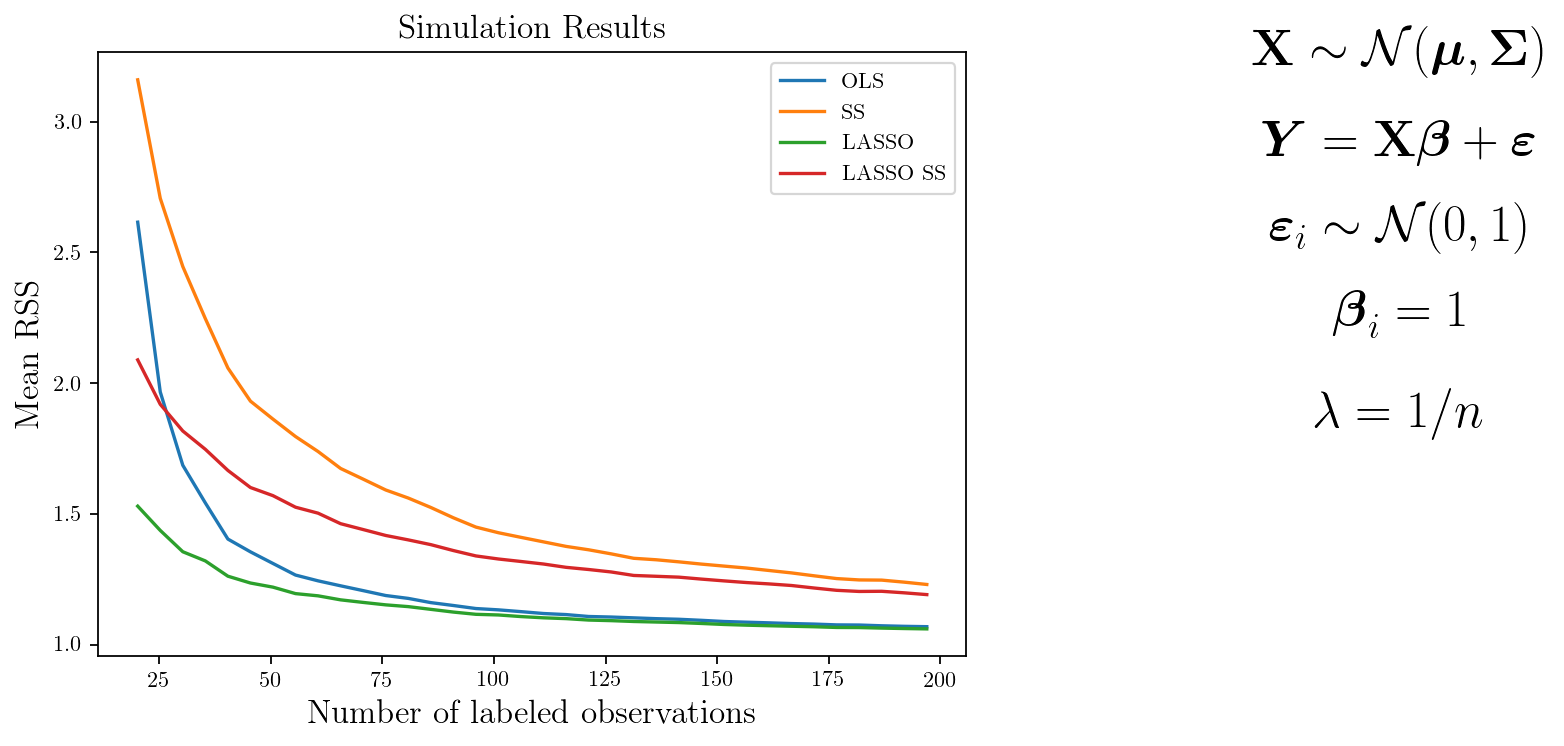

In [512]:
plt.figure(figsize = (7,5), dpi = 80)

ax = plt.gca()
line_ols, = plt.plot(risk_1[0, :], risk_1[1, :], label = "OLS")
line_ss, = plt.plot(risk_1[0, :], risk_1[2, :], label = "SS")
line_lasso, = plt.plot(risk_1[0, :], risk_1[3, :], label = "LASSO")
line_lasso_ss, = plt.plot(risk_1[0, :], risk_1[4, :], label = "LASSO SS")


plt.legend(handles = [line_ols, line_ss, line_lasso, line_lasso_ss])
plt.title("Simulation Results", fontsize = 15)
plt.xlabel("Number of labeled observations", fontsize = 15)
plt.ylabel("Mean RSS", fontsize = 15)
plt.text(1.5, 1,r'$\mathbf{X} \sim \mathcal{N} (\boldsymbol \mu, \boldsymbol \Sigma)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)
plt.text(1.5, 0.85,r'$\boldsymbol Y = \mathbf{X} \boldsymbol \beta + \boldsymbol \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)
plt.text(1.5, 0.7,r'$\boldsymbol \varepsilon_{i} \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)

plt.text(1.5, 0.55,r'$\boldsymbol \beta_i = 1$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23);

plt.text(1.5, 0.4,r'$\lambda = 1/n$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23);

The graph above describes the performance of the estimators in the case where $Y$ is generated as a linear combination of columns of matrix $X$ that was generated by multinomial normal distribution with random covariance matrix. Now we will check the prefomance by generating nonlinear $Y$. We will also compare our method with kernel regression.

In [29]:
np.random.seed(42)
risk_2 = execute_simulations(begin = 20, step = 5, end = 200, dim = 10, kernel = True, generator= generate_nonlinear_data)
for i in range(100):
    a = execute_simulations(begin = 20, step = 5, end = 200, dim = 10, kernel = True, generator= generate_nonlinear_data)
    risk_2 += a

risk_2 = risk_2/ 100.

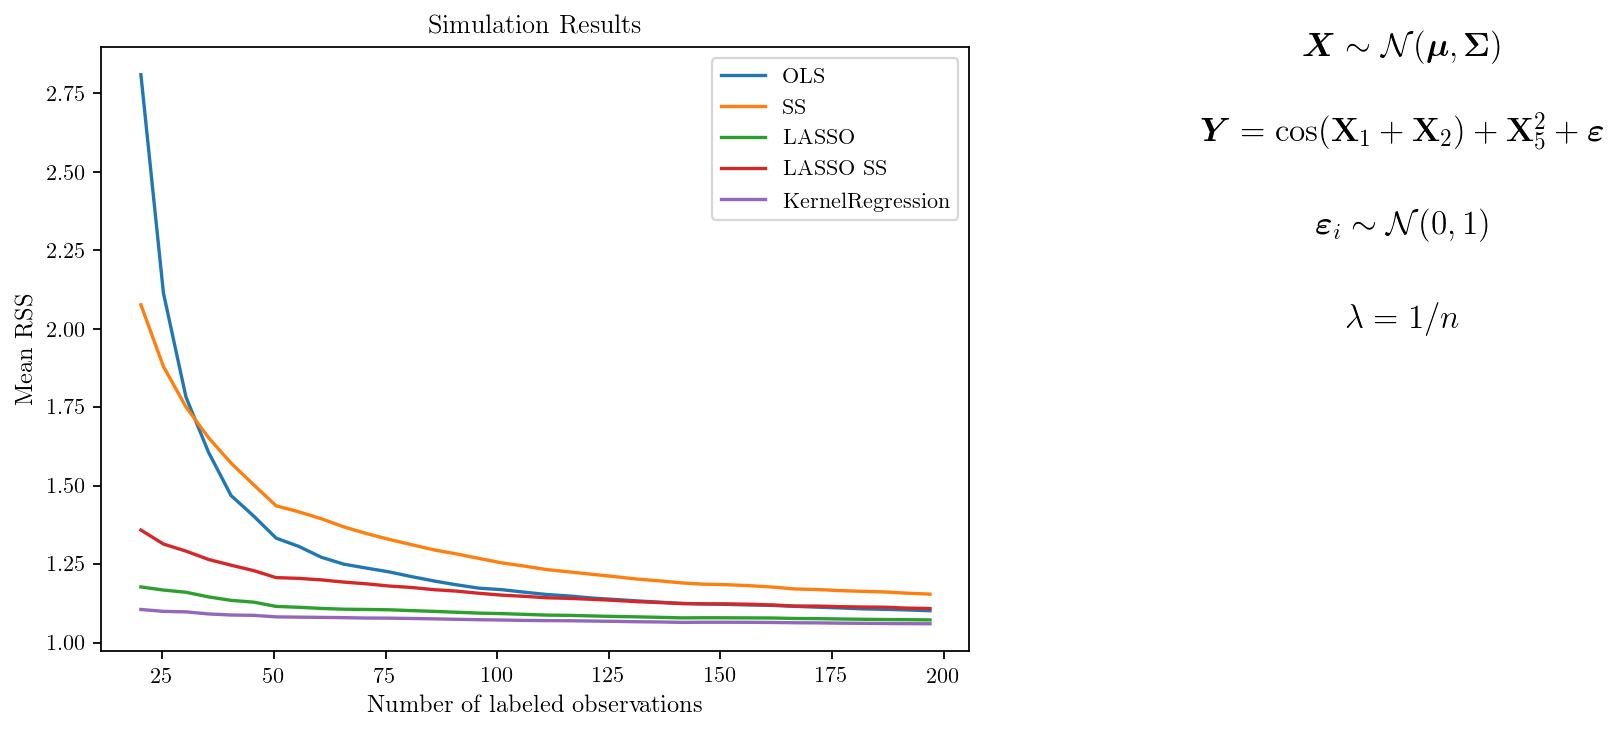

In [63]:
plt.figure(figsize = (7,5), dpi = 80)

ax = plt.gca()
line_ols, = plt.plot(risk_2[0, :], risk_2[1, :], label = "OLS")
line_ss, = plt.plot(risk_2[0, :], risk_2[2, :], label = "SS")
line_lasso, = plt.plot(risk_2[0, :], risk_2[3, :], label = "LASSO")
line_lasso_ss, = plt.plot(risk_2[0, :], risk_2[4, :], label = "LASSO SS")
line_kernel, = plt.plot(risk_2[0, :], risk_2[5, :], label = "KernelRegression")
plt.legend(handles = [line_ols, line_ss, line_lasso, line_lasso_ss, line_kernel])
plt.title("Simulation Results")
plt.xlabel("Number of labeled observations", fontsize = 11)
plt.ylabel("Mean RSS", fontsize = 11)

plt.text(1.5, 1,r'$\boldsymbol X \sim \mathcal{N} (\boldsymbol \mu, \boldsymbol \Sigma)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.85,r'$\boldsymbol Y = \cos (\mathbf{X}_1 + \mathbf{X}_2) + \mathbf{X}_5^2 + \boldsymbol \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.7,r'$\boldsymbol \varepsilon_i \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

plt.text(1.5, 0.55,r'$\lambda = 1/n$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);


As we can see, kernel regression preforms much better. So it is even has no sense to compare it. Let us compare OLS and SS with linear and nonlinear data with a uniformly distributed data.

In [35]:
def generate_uniform_linear(n = 100, test_n = 5000, dim = 5, sparse = False):
    X = np.random.normal(0, 1, (n, dim))
    X = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X)
    beta = np.random.random(dim) * 2
    if sparse == True:
        sparcity_vector = np.random.binomial(1, 0.2, size=dim)
        beta = sparcity_vector * beta
    
    y = np.dot(X, beta) + np.random.normal(0, 1, n)
    X_test = np.random.normal(0, 1, (test_n, dim))
    X_test = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X_test)
    y_test = np.dot(X_test, beta) + np.random.normal(0, 1, test_n)
    
    return (X, y, X_test, y_test)

In [36]:
np.random.seed(42)
risk_3 = execute_simulations(begin = 25, end = 200, dim = 20, step = 5, generator= generate_uniform_linear, sparse = True)
for i in range(100):
    a = execute_simulations(begin = 25, end = 200, dim = 20, step = 5,  generator= generate_uniform_linear, sparse = True)
    risk_3 += a

risk_3 = risk_3 / 100.

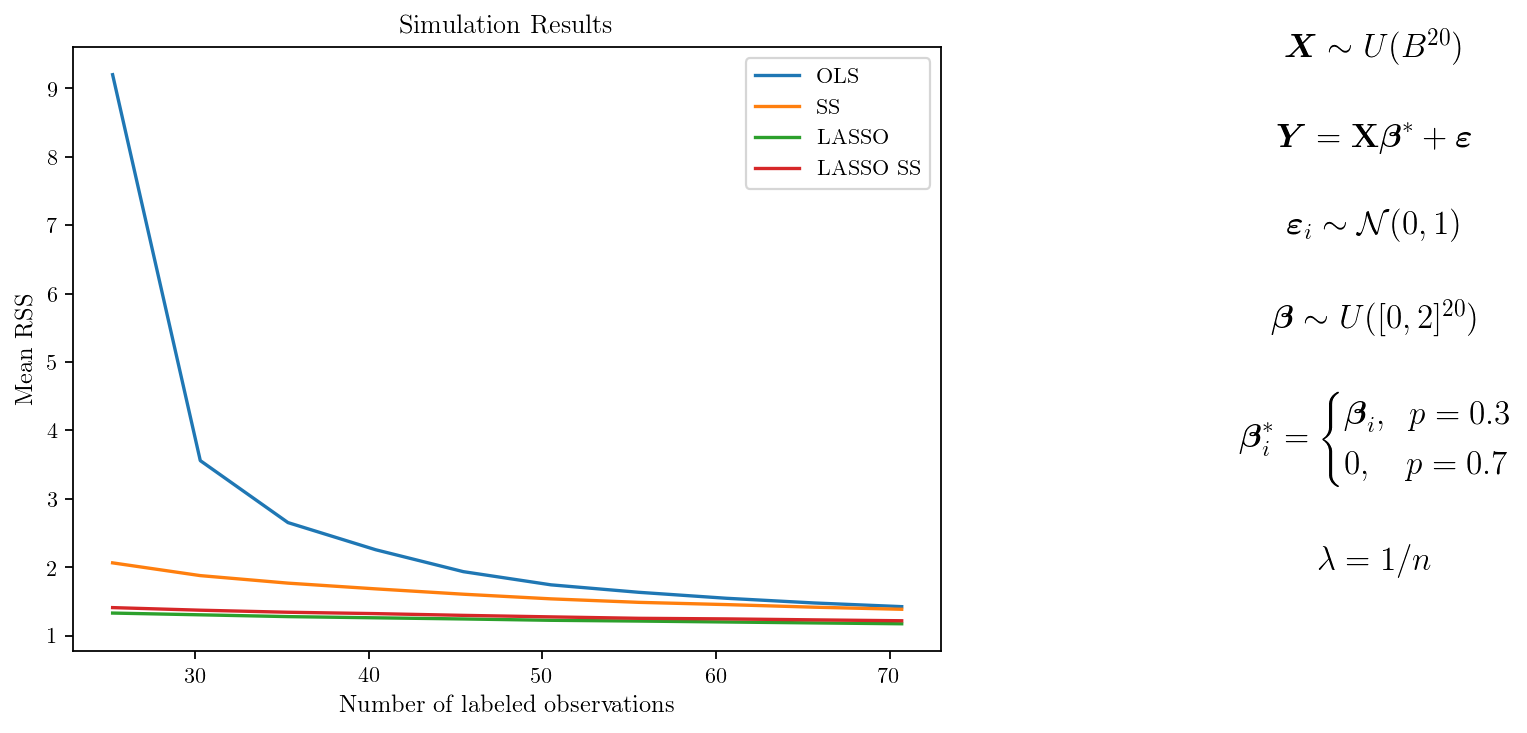

In [65]:
plt.figure(figsize = (7,5), dpi = 80)

ax = plt.gca()
line_ols, = plt.plot(risk_3[0, :10], risk_3[1, :10], label = "OLS")
line_ss, = plt.plot(risk_3[0, :10], risk_3[2, :10], label = "SS")
line_lasso, = plt.plot(risk_3[0, :10], risk_3[3, :10], label = "LASSO")
line_lasso_ss, = plt.plot(risk_3[0, :10], risk_3[4, :10], label = "LASSO SS")
plt.legend(handles = [line_ols, line_ss, line_lasso, line_lasso_ss])
plt.title("Simulation Results")
plt.ylabel("Mean RSS", fontsize = 11)
plt.xlabel("Number of labeled observations", fontsize = 11)

plt.text(1.5, 1,r'$\boldsymbol X \sim U (B^{20})$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.85,r'$\boldsymbol Y = \mathbf{X}\boldsymbol \beta^* + \boldsymbol \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.7,r'$\boldsymbol \varepsilon_i \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)

plt.text(1.5, 0.55,r'$\boldsymbol \beta \sim U([0,2]^{20})$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);


plt.text(1.5, 0.35,
         r'\begin{equation*} \boldsymbol \beta_i^* = \begin{cases} \boldsymbol \beta_i, \hspace{3mm} p = 0.3 \\ 0, \hspace{5mm}  p = 0.7 \end{cases}\end{equation*}', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

plt.text(1.5, 0.15,r'$\lambda = 1/n$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

In [498]:
def generate_uniform_nonlinear(n = 100, test_n = 5000, dim = 5, sparse = False):
    X = np.random.normal(0, 1, (n, dim))
    X = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X) * 10

    
    #y = np.dot(X, beta) + np.random.normal(0, 1, n)
    y = X[:, 1] ** 2  + X[:, 2] * X[:, 3] + np.random.normal(0, 1, n)
    X_test = np.random.normal(0, 1, (test_n, dim))
    X_test = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X_test)
    #y_test = np.dot(X_test, beta) + np.random.normal(0, 1, test_n)
    y_test = X_test[:, 1] ** 2 + X_test[:, 2] * X_test[:, 3] + np.random.normal(0, 1, test_n)
    return (X, y, X_test, y_test)

In [499]:
np.random.seed(42)
risk_4 = execute_simulations(begin = 10, end = 200, dim = 5, step = 5, generator = generate_uniform_nonlinear)
for i in range(1000):
    a = execute_simulations(begin = 10, end = 200, dim = 5, step = 5, generator = generate_uniform_nonlinear)
    risk_4 += a
risk_4 = risk_4 / 100.

In [500]:
risk_4 = risk_4 / 10.

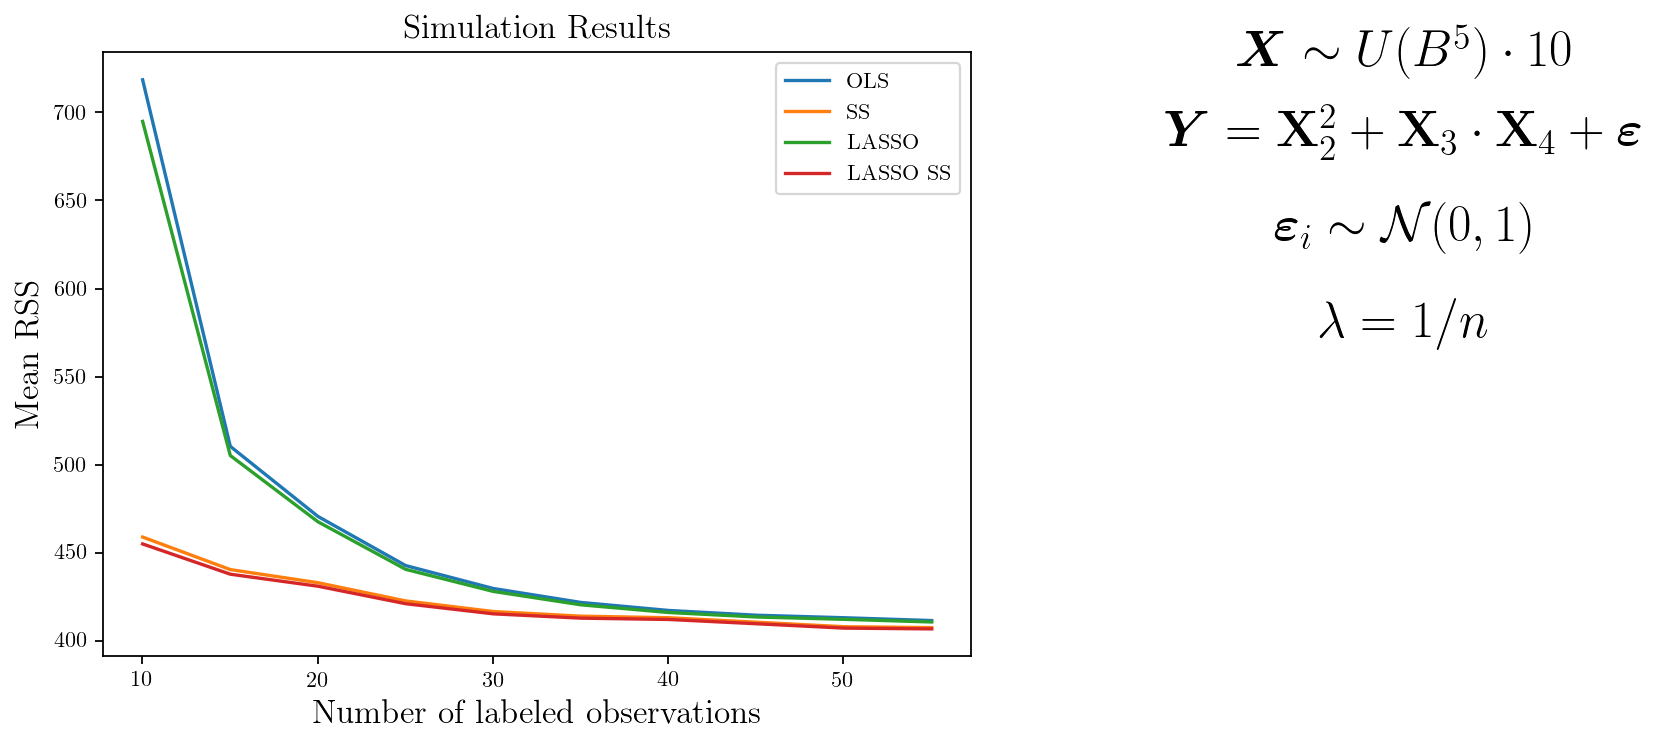

In [508]:
plt.figure(figsize = (7,5), dpi = 80)

ax = plt.gca()
line_ols, = plt.plot(risk_4[0, :10], risk_4[1, :10], label = "OLS")
line_ss, = plt.plot(risk_4[0, :10], risk_4[2, :10], label = "SS")
line_lasso, = plt.plot(risk_4[0, :10], risk_4[3, :10], label = "LASSO")
line_lasso_ss, = plt.plot(risk_4[0, :10], risk_4[4, :10], label = "LASSO SS")
plt.legend(handles = [line_ols, line_ss, line_lasso, line_lasso_ss])


plt.xlabel("Number of labeled observations", fontsize = 15)
plt.ylabel("Mean RSS", fontsize = 15)
plt.title("Simulation Results", fontsize = 15);
plt.text(1.5, 1,r'$\boldsymbol X \sim U (B^5) \cdot 10$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)
plt.text(1.5, 0.85,r'$\boldsymbol Y = \mathbf{X}_2^2 + \mathbf{X}_3 \cdot \mathbf{X}_4 + \boldsymbol \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)
plt.text(1.5, 0.7,r'$\boldsymbol \varepsilon_i \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)

plt.text(1.5, 0.55,r'$\lambda = 1/n$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23);

# Case where dimension is higher than number of observations

In [503]:
def generate_uniform_nonlinear(n = 100, test_n = 5000, dim = 5, sparse = False):
    X = np.random.normal(0, 1, (n, dim))
    X = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X) * 10

    
    #y = np.dot(X, beta) + np.random.normal(0, 1, n)
    y = X[:, 1] ** 2  + X[:, 2] * X[:, 3] + np.random.normal(0, 1, n)
    X_test = np.random.normal(0, 1, (test_n, dim))
    X_test = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X_test)
    #y_test = np.dot(X_test, beta) + np.random.normal(0, 1, test_n)
    y_test = X_test[:, 1] ** 2 + X_test[:, 2] * X_test[:, 3] + np.random.normal(0, 1, test_n) + 10
    return (X, y, X_test, y_test)

In [504]:
np.random.seed(42)
risk_5 = execute_simulations(begin = 10, end = 100, dim = 50, step = 5, generator = generate_uniform_nonlinear, OLS = False)
for i in range(500):
    a = execute_simulations(begin = 10, end = 100, dim = 50, step = 5, generator = generate_uniform_nonlinear, OLS = False)
    risk_5 += a
risk_5 = risk_5 / 500.

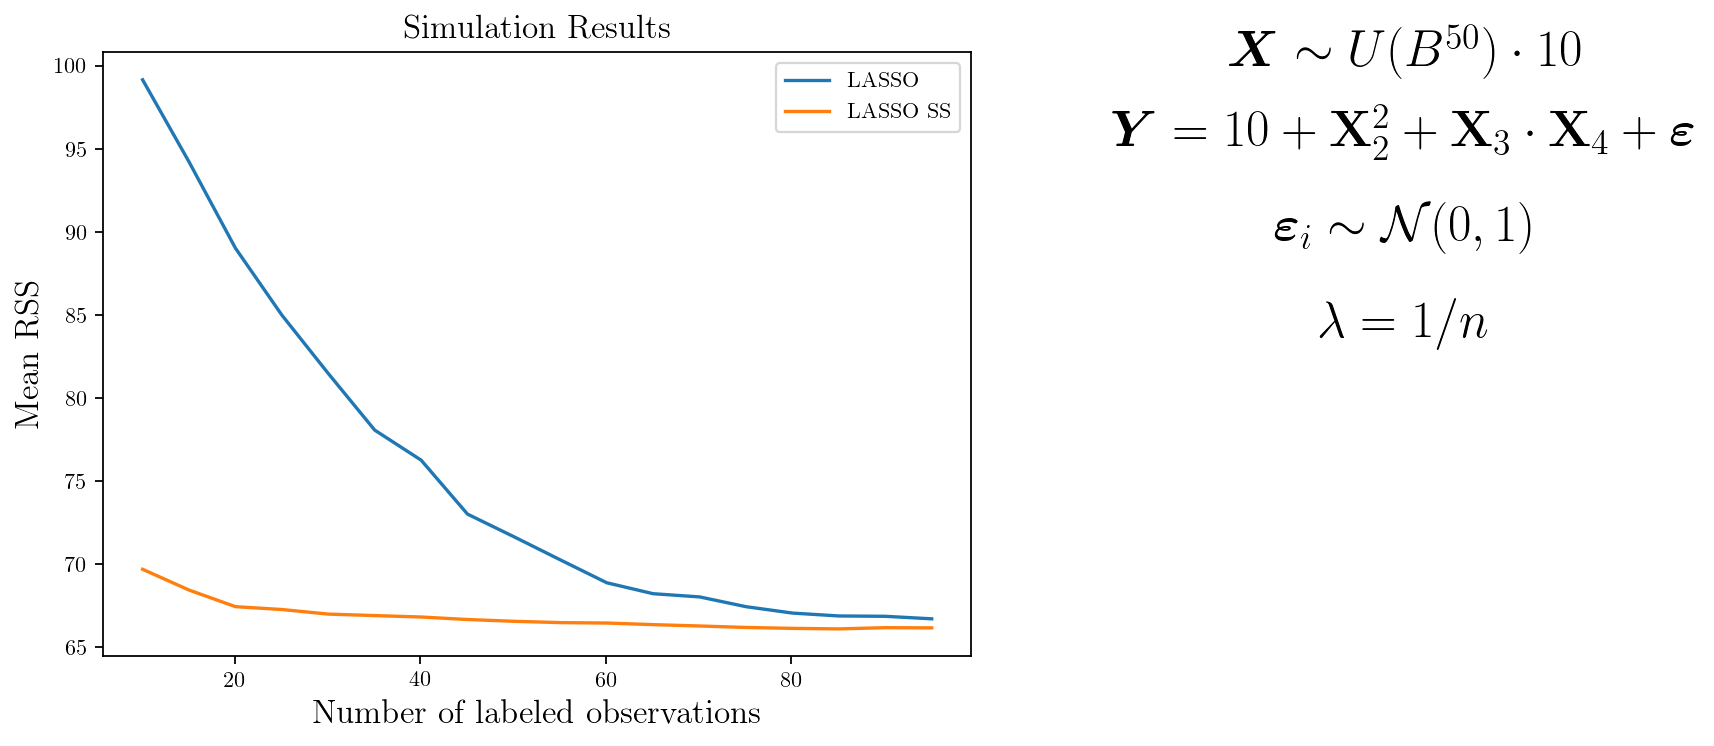

In [506]:
plt.figure(figsize = (7,5), dpi = 80)
ax = plt.gca()

line_lasso, = plt.plot(risk_5[0, :], risk_5[3, :], label = "LASSO")
line_lasso_ss, = plt.plot(risk_5[0, :], risk_5[4, :], label = "LASSO SS")
plt.legend(handles = [line_lasso, line_lasso_ss])


plt.xlabel("Number of labeled observations", fontsize = 15)
plt.ylabel("Mean RSS", fontsize = 15)
plt.title("Simulation Results", fontsize = 15);
plt.text(1.5, 1,r'$\boldsymbol X \sim U (B^{50}) \cdot 10$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)
plt.text(1.5, 0.85,r'$\boldsymbol Y = 10 + \mathbf{X}_2^2 + \mathbf{X}_3 \cdot \mathbf{X}_4 + \boldsymbol \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)
plt.text(1.5, 0.7,r'$\boldsymbol \varepsilon_i \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)
plt.text(1.5, 0.55,r'$\lambda = 1/n$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23);

# Exponential distribution of X

In [483]:
def generate_uniform_nonlinear(n = 100, test_n = 5000, dim = 5, sparse = False):
    X = np.random.normal(0, 1, (n, 2))

    
    #y = np.dot(X, beta) + np.random.normal(0, 1, n)
    y = np.sqrt(np.abs(X[:, 0])) + np.random.normal(0, 1, n) + 2
    X_test = np.random.normal(0, 1, (test_n, 2))
    #y_test = np.dot(X_test, beta) + np.random.normal(0, 1, test_n)
    y_test = np.sqrt(np.abs(X_test[:, 0])) + np.random.normal(0, 1, test_n) + 2
    return (X, y, X_test, y_test)

In [484]:
np.random.seed(42)
risk_6 = execute_simulations(begin = 10, end = 100, dim = 2, step = 5, generator = generate_uniform_nonlinear)
for i in range(100):
    a = execute_simulations(begin = 10, end = 100, dim = 2, step = 5, generator = generate_uniform_nonlinear)
    risk_6 += a
risk_6 = risk_6 / 100.

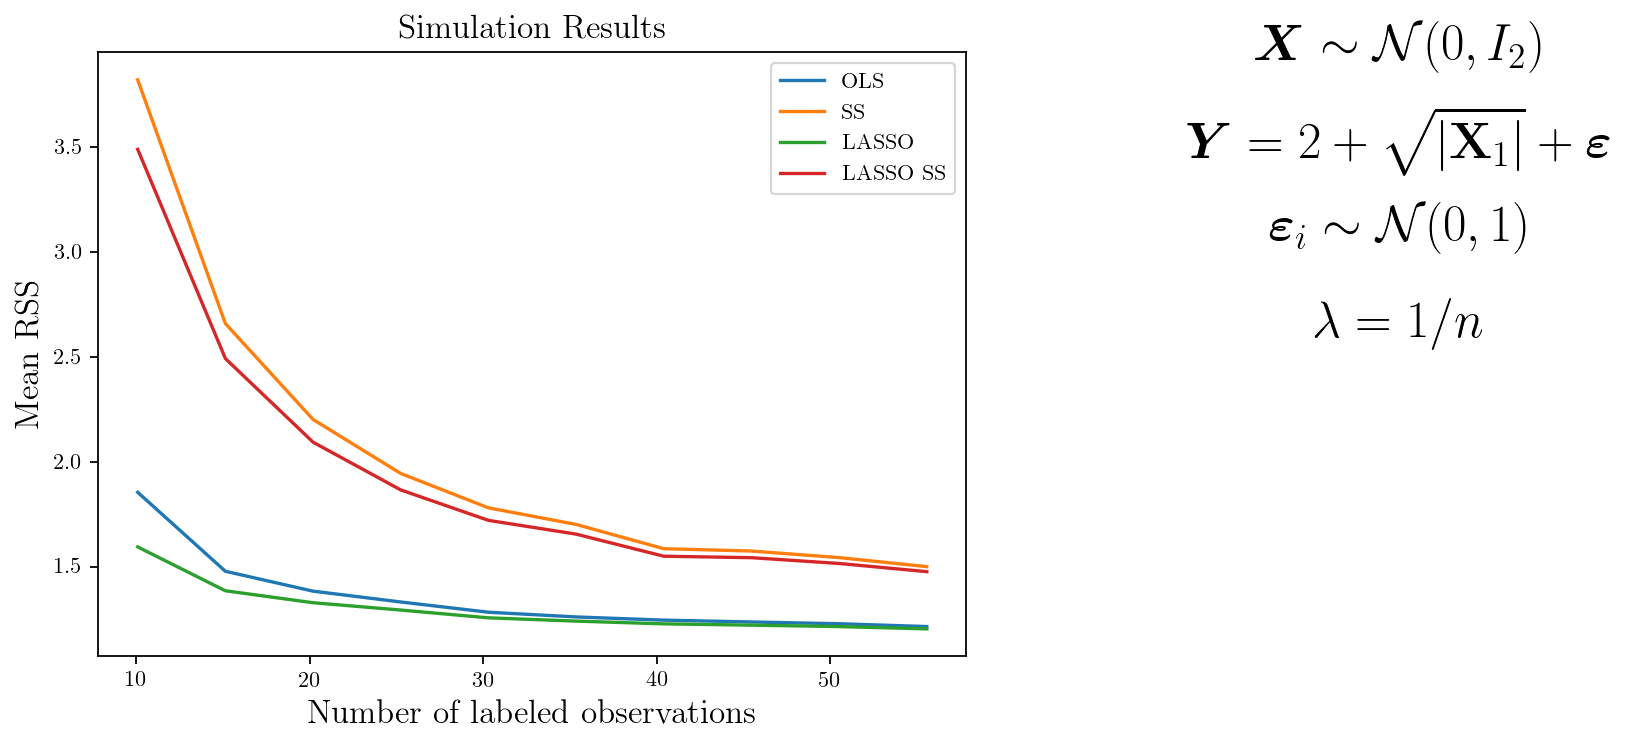

In [497]:
plt.figure(figsize = (7,5), dpi = 80)

ax = plt.gca()
line_ols, = plt.plot(risk_6[0, :10], risk_6[1, :10], label = "OLS")
line_ss, = plt.plot(risk_6[0, :10], risk_6[2, :10], label = "SS")
line_lasso, = plt.plot(risk_6[0, :10], risk_6[3, :10], label = "LASSO")
line_lasso_ss, = plt.plot(risk_6[0, :10], risk_6[4, :10], label = "LASSO SS")
plt.legend(handles = [line_ols, line_ss, line_lasso, line_lasso_ss])


plt.xlabel("Number of labeled observations", fontsize = 15)
plt.ylabel("Mean RSS", fontsize = 15)
plt.title("Simulation Results",fontsize = 15);
plt.text(1.5, 1,r'$\boldsymbol X \sim \mathcal{N}(0, I_2)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)
plt.text(1.5, 0.85,r'$\boldsymbol Y = 2 + \sqrt{|\mathbf{X}_1|} + \boldsymbol \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)
plt.text(1.5, 0.7,r'$\boldsymbol \varepsilon_i \sim \mathcal{N}(0,1)$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23)

plt.text(1.5, 0.55,r'$\lambda = 1/n$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 23);

# Normal truncated noise

In [ ]:
import scipy

def generate_uniform_nonlinear(n = 100, test_n = 5000, dim = 5, sparse = False):
    X = np.random.normal(0, 1, (n, dim))
    X = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X) * 

    
    #y = np.dot(X, beta) + np.random.normal(0, 1, n)
    y = X[:, 1] ** 2  + X[:, 2] * X[:, 3] + scipy.stats.truncnorm.rvs(-2,2, n)
    X_test = np.random.normal(0, 1, (test_n, dim))
    X_test = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x ** 2)), 1, X_test)
    #y_test = np.dot(X_test, beta) + np.random.normal(0, 1, test_n)
    y_test = X_test[:, 1] ** 2 + X_test[:, 2] * X_test[:, 3] + scipy.stats.truncnorm.rvs(-2,2, n)
    return (X, y, X_test, y_test)

In [ ]:
risk = execute_simulations(begin = 10, end = 100, dim = 50, step = 5, generator = generate_uniform_nonlinear, OLS = False)
for i in range(100):
    a = execute_simulations(begin = 10, end = 100, dim = 50, step = 5, generator = generate_uniform_nonlinear, OLS = False)
    risk += a
risk[0, :] = risk[0, :] / 100

In [ ]:
ax = plt.gca()

line_lasso, = plt.plot(risk[0, :], risk[3, :], label = "LASSO")
line_lasso_ss, = plt.plot(risk[0, :], risk[4, :], label = "LASSO SS")
plt.legend(handles = [line_lasso, line_lasso_ss])


plt.xlabel("Number of labeled observations", fontsize = 11)
plt.ylabel("RSS", fontsize = 11)
plt.title("Simulations with uniformly distributed data");
plt.text(1.5, 1,r'$X \sim U (B^5) \cdot 2$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.85,r'$Y = X_2^2 + X_3 \cdot X_4 + \varepsilon$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.7,r'$\varepsilon \sim \mathcal{N}_T[-2, 2]$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15)
plt.text(1.5, 0.55,r'$\lambda = 0.1$', horizontalalignment='center',
     verticalalignment='center',
     transform=ax.transAxes, fontsize = 15);

# Simulations with real data

In [291]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
data = load_svmlight_file('YearPredictionMSD')

In [417]:
def bootstrap_std(X):
    return np.std(np.mean(np.random.choice(X, (10000, len(X_test))), axis = 1))

In [387]:
y = data[1]
X = np.array(data[0].todense())

In [399]:
X = scale(X[:10000])
y = scale(y[:10000])

In [400]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [401]:
las = Lasso(fit_intercept=False)
cv = GridSearchCV(las, cv=5, n_jobs=-1, param_grid={'alpha': np.linspace(0.01, 1, 10)})

In [424]:
cv.fit(X_train[:50], y_train[:50])

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': array([ 0.01,  0.12,  0.23,  0.34,  0.45,  0.56,  0.67,  0.78,  0.89,  1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [425]:
las = Lasso(alpha = cv.best_params_['alpha'], max_iter=10000,  fit_intercept=False)
las.fit(X_train[:100], y_train[:100])

Lasso(alpha=0.12, copy_X=True, fit_intercept=False, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [426]:
print np.mean((las.predict(X_test) - y_test)**2)
print bootstrap_std((las.predict(X_test) - y_test)**2)

1.12081301995
0.0295596383001


In [427]:
A = np.dot(X_train.T, X_train)/len(X_train)

In [428]:
A = scipy.linalg.sqrtm(A)

In [440]:
beta = lasso_estimation(A, X_train[:1000], y_train[:1000], lamda=0.02)

In [441]:
np.mean((np.dot(X_test, beta) - y_test)**2)

0.83941446291872868

In [442]:
bootstrap_std((np.dot(X_test, beta) - y_test)**2)

0.023155352121412287

In [171]:
from sklearn.model_selection import KFold

In [439]:
lambdas = np.linspace(0.01, 0.1, 10)
kf = KFold(n_splits=5, random_state=42)
for l in lambdas:
    result = 0.
    for train_index, test_index in kf.split(X_train):
        A = np.dot(X_train[train_index].T, X_train[train_index])/len(X_train[train_index])
        A = scipy.linalg.sqrtm(A)
        beta = lasso_estimation(A, X_train[train_index][:1000], y_train[train_index][:1000], lamda=l)
        result += compute_rss(X_train[test_index], y_train[test_index], beta)
    print 'Lambda: ' + str(l)
    print 'Mean RSS: ' + str(result/5.)
    print
    

Lambda: 0.01
Mean RSS: 0.80143968095

Lambda: 0.02
Mean RSS: 0.798141247115

Lambda: 0.03
Mean RSS: 0.805964482698



KeyboardInterrupt: 